In [12]:
import jax 
import jax.numpy as jnp
import optax 
from rfp import MLP, Model_Params, Cluster_Loss, Supervised_Loss, loss_fn_real, Trainer, predict 
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [13]:

def plot_data(batch):
  X, Y = batch
  fig = plt.figure(dpi=300, tight_layout=True, figsize=(6.4, 4.8))
  for i in range(X.shape[0]):
    plt.scatter(X[i], Y[i], label=i)
  plt.legend(title=r'$E[Y|C=i]$', ncol=2, fontsize='xx-small', frameon=False)
  plt.title(r'$Y$', loc='left')
  plt.xlabel(r'$X$')
  fig.savefig('motivating_cefs.pdf', format='pdf')
  plt.show()

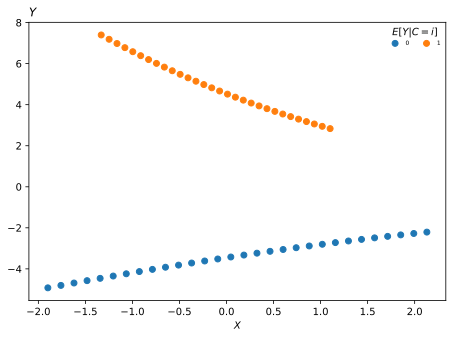

In [14]:
def polynomial(weights, x):
  return weights[0] + weights[1]*x + .5*weights[2]*x**2 + (1/6)*weights[3]*x**3

def get_data(key, n_obs):
  key, subkey1, subkey2, subkey3 = jax.random.split(key, 4)
  x_start = jax.random.uniform(subkey1, shape=(1,), minval=-3., maxval=-2.)
  lenth = jax.random.uniform(subkey2, shape=(1,), minval=1., maxval=4.)
  x = jnp.linspace(x_start, x_start + lenth, n_obs)
  weights = jax.random.normal(subkey3, shape=(4,))
  y = jax.vmap(polynomial, in_axes=(None, 0))(weights, x)
  return x, y

n_obs = 30
n_cohorts = 2
batch = jax.vmap(get_data, in_axes=(0, None))(jax.random.split(jax.random.PRNGKey(2), n_cohorts), n_obs)
batch = ((batch[0] - jnp.mean(batch[0]))/jnp.std(batch[0]), batch[1])
single_x, single_y = batch[0].squeeze().reshape(-1,1), batch[1].squeeze().reshape(-1,1)
plot_data(batch)

In [37]:
width = 64
mlp = MLP([width, width])

In [38]:
supervised_loss = Supervised_Loss(loss_fn = loss_fn_real, 
                                    feature_map = mlp.embellished_fwd_pass,
                                    reg_value = 0.0, 
                                    aux_status = False)

In [39]:
model_params = Model_Params(mlp.init_fn(jax.random.PRNGKey(0), 1),                      # Base
                            jax.random.normal(jax.random.PRNGKey(0), shape=(width,)),   # Head
                            jnp.zeros(shape=()))                                        # Bias

In [40]:
single_cluster = {'Y': batch[1][0], 'X': batch[0][0], 'Weight': jnp.ones_like(batch[0][0])}

(2, 30, 1)
(2, 30, 1)
(2, 30, 1)


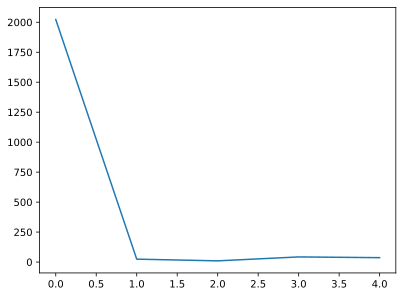

In [47]:

inner_yuri = Trainer(loss_fn = supervised_loss, 
                    opt = optax.sgd(learning_rate=0.001), 
                    epochs = 3)

cluster_loss = Cluster_Loss(inner_yuri, reg_value=1., aux_status=False)

yuri = Trainer(cluster_loss, optax.sgd(learning_rate=0.001, momentum=0.9), 1000)

Y = jnp.vstack((jnp.expand_dims(batch[1][0],0),jnp.expand_dims(batch[1][1],0)))
X =  jnp.vstack((jnp.expand_dims(batch[0][0],0), jnp.expand_dims(batch[0][1],0)))
W = jnp.ones_like(X)

cluster_data = {'Y': Y, 'X':X, 'Weight': W}
print(Y.shape)
print(X.shape)
print(W.shape)

cluster_loss(model_params, cluster_data)
opt_params, losses = yuri.train(model_params, cluster_data)

plt.plot(losses)
plt.show()

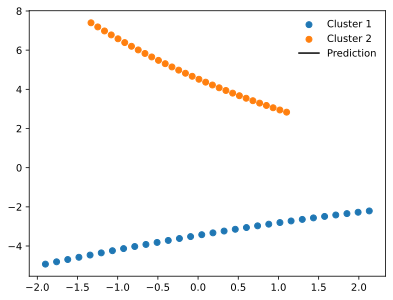

In [49]:
yhat_post = predict(False, mlp.fwd_pass, opt_params, single_cluster['X'])
plt.scatter(cluster_data['X'][0], cluster_data['Y'][0], label='Cluster 1')
plt.scatter(cluster_data['X'][1], cluster_data['Y'][1], label='Cluster 2')
plt.plot(single_cluster['X'], yhat_post, label='Prediction', color='black')
plt.legend(frameon=False)
plt.show()

In [50]:
yhat_post

Array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan], dtype=float32)